source : https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/blob/master/Chapter%204/Ch4_book.ipynb

In [1]:
import numpy as np
import torch
import torch.nn as nn
import gymnasium as gym
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

In [3]:
args = {
    'learning_rate': 0.003,
    'truncated' : 500,
    'total_episodes' : 2000,
}

In [4]:
env = gym.make("CartPole-v1")

In [5]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=0)
        )

    def forward(self, x):
        return self.network(x)

In [6]:
model = QNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=args['learning_rate'])

In [7]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    # disc_return : r, γr, γ^2r, ..., γ^{t-1}r_t
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards
    disc_return /= disc_return.max() # normalization
    return disc_return

In [8]:
def loss_fn(preds, r):
    # -logπ(a|s) * G_t, G: discounted return
    return -1 * torch.sum(r * torch.log(preds))

In [9]:
score = [] #A
expectation = 0.0
for episode in tqdm(range(args['total_episodes'])):
    curr_state, _ = env.reset()
    done = False
    transitions = [] #B
    
    for t in range(args['truncated']): #C
        act_prob = model(torch.from_numpy(curr_state).float()) #D
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()) #E
        prev_state = curr_state
        curr_state, _, terminated, _, info = env.step(action) #F
        transitions.append((prev_state, action, t+1)) #G
        if terminated: #H
            break

    ep_len = len(transitions) #I
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) #J
    disc_returns = discount_rewards(reward_batch) #K
    state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions])) #L
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) #M
    pred_batch = model(state_batch) #N
    # (batch_size, 1) -> (batch_size)
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() #O
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 2000/2000 [02:22<00:00, 14.02it/s]


In [10]:
score = np.array(score)
# avg_score = running_mean(score, 50)

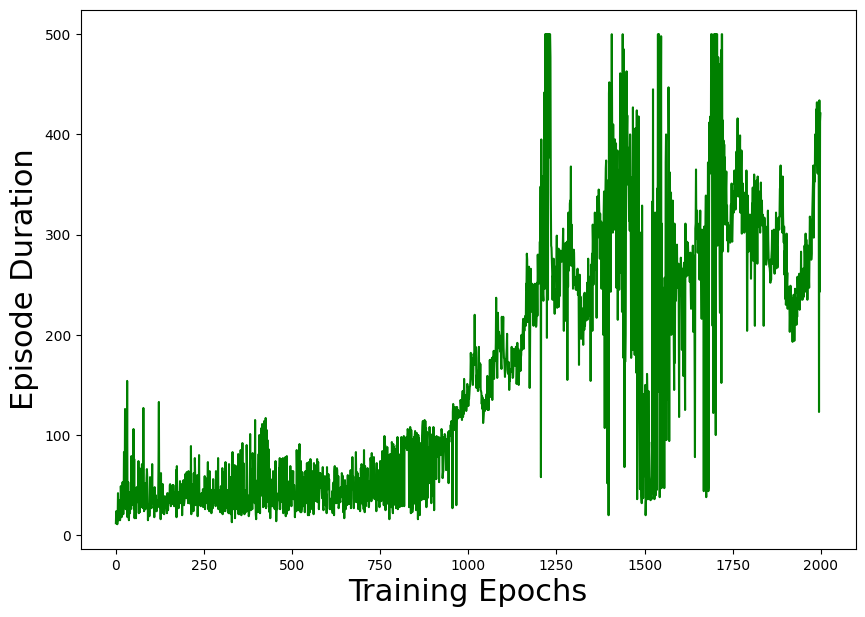

In [11]:
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
# plt.plot(avg_score, color='green')
plt.plot(score, color='green')